## mapping tests 

In [2]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import random
from snipgenie import trees, app, snp_typing
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [3]:
counties = gpd.read_file('https://github.com/dmnfarrell/snipgenie/raw/master/maps/ireland_counties.zip?raw=true')

## make fake data for map/db testing with web app

In [5]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/ireland_metadata.csv',index_col=0)
#meta = meta.drop(columns=['filename','pair'])
#meta = meta.rename(columns={'SB':'spoligotype'})
meta['species'] = meta.species.fillna('Cow')
meta['name'] = meta.index
meta

,county,species,source,batch,aliquot,county1,county2,filename,SB,SequenceName,snp10,snp100,snp12,snp20,snp3,snp5,snp50,snp7,SB1,name
sample,,,,,,,,,,,,,,,,,,,,
ERR125617,NI,Cow,Other,NaN,NaN,NI,Other,/storage/btbgenie/mbovis_ireland/NI/ERR125617_...,SB0140,ERR125617,66,23,71,63,74,83,37,69,SB0140,ERR125617
ERR125622,NI,Cow,Other,NaN,NaN,NI,Other,/storage/btbgenie/mbovis_ireland/NI/ERR125622_...,SB0140,ERR125622,66,23,71,63,-1,83,37,69,SB0140,ERR125622
ERR125598,NI,Cow,Other,NaN,NaN,NI,Other,/storage/btbgenie/mbovis_ireland/NI/ERR125598_...,SB0140,ERR125598,66,23,71,63,-1,-1,37,69,SB0140,ERR125598
ERR125612,NI,Cow,Other,NaN,NaN,NI,Other,/storage/btbgenie/mbovis_ireland/NI/ERR125612_...,SB0140,ERR125612,66,23,71,63,-1,-1,37,69,SB0140,ERR125612
ERR125603,NI,Cow,Other,NaN,NaN,NI,Other,/storage/btbgenie/mbovis_ireland/NI/ERR125603_...,SB0140,ERR125603,65,23,70,63,-1,-1,37,-1,SB0140,ERR125603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307_Bov_2013_2.142,NI,Cow,AFBI,NaN,NaN,NI,Other,NaN,NaN,307_Bov_2013_2.142,77,20,82,80,59,79,33,80,Other,307_Bov_2013_2.142
324_Bov_2015_2.142,NI,Cow,AFBI,NaN,NaN,NI,Other,NaN,NaN,324_Bov_2015_2.142,-1,20,-1,-1,-1,-1,33,-1,Other,324_Bov_2015_2.142
346_Bov_2016_5.140,NI,Cow,AFBI,NaN,NaN,NI,Other,NaN,NaN,346_Bov_2016_5.140,38,17,41,36,-1,-1,25,-1,Other,346_Bov_2016_5.140


<AxesSubplot:ylabel='source'>

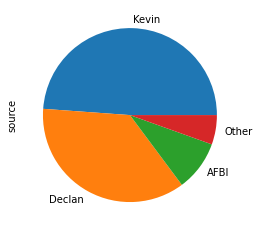

In [25]:
meta.source.value_counts().plot(kind='pie')

In [6]:
def make_points(x):
    """Make points"""

    if x.county == 'Wicklow':
        bounds=(-6.7,52.8,-6.1,53.2)
    elif x.county == 'Monaghan':
        bounds = (-6.0,54.0,-7.1,54.5)
    else:
        bounds = (-6.4,53.8,-6.1,54.2)
    points = []
    minx, miny, maxx, maxy = bounds   
    point = (random.uniform(minx, maxx), random.uniform(miny, maxy))
    return point

In [13]:
#make random points inside geometry

from shapely.geometry import Point
def random_point_in_shp(x):
   
    if x.county not in counties.NAME_TAG.unique():
        x.county=random.choice(['Armagh'])
    shp = counties[counties.NAME_TAG==x.county].iloc[0] 
    #print (shp)
    within = False
    bounds = shp.geometry.bounds    
    while within is False:
        x = np.random.uniform(bounds[0], bounds[2])
        y = np.random.uniform(bounds[1], bounds[3])        
        within = shp.geometry.contains(Point(x, y))
        #print (within)
    return x,y

#meta.apply(random_point_in_shp,1)

In [14]:
meta['coord'] = meta.apply(random_point_in_shp,1)
meta[['LONG','LAT']] = pd.DataFrame(meta.coord.tolist(), index=meta.index)

In [15]:
sdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
#print (sdist)

def find_neighbours(x, n=4):
    """find neighbours from snp distance matrix"""
  
    vals = list(x.sort_values()[1:n].index)
    return ';'.join(vals)

nearest = sdist.apply(find_neighbours,1)
#nearest
meta['nearest'] = nearest

## encode snp data into field

In [16]:
snpm = pd.read_csv('/storage/btbgenie/all_ireland_results/core.txt',sep=' ').set_index('pos').T
snpm = snpm.fillna('N')
meta['snps'] = snpm.apply(snp_typing.encode_snps,1)

In [17]:
print (meta[:4])
meta.to_csv('ireland_test_data.csv')

          county species source  batch aliquot county1 county2                                           filename      SB SequenceName  ...  snp50  snp7     SB1       name  \
sample                                                                                                                                  ...                                   
ERR125617     NI     Cow  Other    NaN     NaN      NI   Other  /storage/btbgenie/mbovis_ireland/NI/ERR125617_...  SB0140    ERR125617  ...     37    69  SB0140  ERR125617   
ERR125622     NI     Cow  Other    NaN     NaN      NI   Other  /storage/btbgenie/mbovis_ireland/NI/ERR125622_...  SB0140    ERR125622  ...     37    69  SB0140  ERR125622   
ERR125598     NI     Cow  Other    NaN     NaN      NI   Other  /storage/btbgenie/mbovis_ireland/NI/ERR125598_...  SB0140    ERR125598  ...     37    69  SB0140  ERR125598   
ERR125612     NI     Cow  Other    NaN     NaN      NI   Other  /storage/btbgenie/mbovis_ireland/NI/ERR125612_...  SB0140    

175

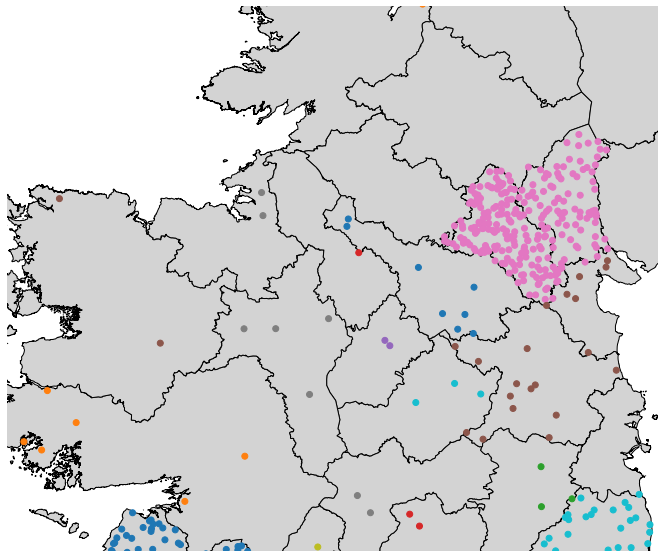

In [27]:
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.LONG, meta.LAT),crs='EPSG:4326')
fig,ax=plt.subplots(1,1,figsize=(10,10))
counties.plot(ax=ax,color='lightgray',ec='black')
gdf.plot(ax=ax,column='county')
ax.set_xlim(-10,-6)
ax.set_ylim(53,55)
plt.tight_layout()
ax.axis('off')
fig.savefig('ireland_samples_map_test.jpg',dpi=150)
len(gdf[gdf.county=='Monaghan'])

## real locations for monaghan with fake NI border geolocs as example?